<a href="https://colab.research.google.com/github/wasim-essbai/MasterThesis/blob/main/evaluation_script_bnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

user = "wasim-essbai"
repo = "MasterThesis"
token = ""

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git config --global user.email "w.essbai@studenti.unibg.it"
!git config --global user.name "wasim-essbai"

!git clone https://{token}@github.com/{user}/{repo}
%cd ./MasterThesis

Cloning into 'MasterThesis'...
remote: Enumerating objects: 338, done.
remote: Counting objects: 100% (338/338), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 338 (delta 157), reused 242 (delta 74), pack-reused 0
Receiving objects: 100% (338/338), 24.89 MiB | 26.55 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/MasterThesis


In [ ]:
!git fetch
!git pull

remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 14 (delta 7), reused 14 (delta 7), pack-reused 0
Unpacking objects: 100% (14/14), 11.63 KiB | 113.00 KiB/s, done.
From https://github.com/wasim-essbai/MasterThesis
   57865e3..40f0813  main       -> origin/main
Updating 57865e3..40f0813
Fast-forward
 workspace/bp_estimation_BNN/bp_bnn.py              |   2 +-
 workspace/bp_estimation_BNN/bp_bnn_train.py        |   2 +-
 .../model/bp_bnn_model/fingerprint.pb              |   2 +-
 .../model/bp_bnn_model/keras_metadata.pb           |  12 ++++++------
 .../model/bp_bnn_model/saved_model.pb              | Bin 4068798 -> 4068845 bytes
 .../variables/variables.data-00000-of-00001        | Bin 2114467 -> 2114467 bytes
 .../model/bp_bnn_model/variables/variables.index   | Bin 1220 -> 1220 bytes
 7 files changed, 9 insertions(+), 9 deletions(-)


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [3]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)
model = keras.models.load_model('/content/MasterThesis/workspace/bp_estimation_BNN/model/bp_bnn_model', compile=False)
X_test = np.load('/content/drive/MyDrive/MasterThesis/workspace/bnn_dataset/x_test.npy')
y_test = np.load('/content/drive/MyDrive/MasterThesis/workspace/bnn_dataset/y_test.npy')

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [4]:
def get_mae_error(y_true, y_pred):
  return abs(y_true - y_pred)

In [5]:
def compute_inefficiency_score1(mae, sigma):
  return (sigma/(mae + 1) + mae/(sigma + 1))

In [6]:
def compute_inefficiency_score2(mae, sigma):
  return 0.5*((sigma + 1)/(mae + 1) + (mae + 1)/(sigma + 1))

In [7]:
def compute_efficiency_score1(mae, sigma):
  return 2/((sigma + 1)/(mae + 1) + (mae + 1)/(sigma + 1))

In [ ]:
print(compute_inefficiency_score1(0,0))
print(compute_inefficiency_score1(1,0))
print(compute_inefficiency_score1(100000,100000))
print(compute_inefficiency_score1(100000,50000))

0.0
1.0
1.999980000199998
2.4999550008499836


In [ ]:
print(compute_efficiency_score1(0,0))
print(compute_efficiency_score1(1,0))
print(compute_efficiency_score1(100000,100000))
print(compute_efficiency_score1(100000,50000))
print(compute_efficiency_score1(10,50000))

1.0
0.8
1.0
0.8000047999168012
0.0004399911788812752


In [8]:
X_test_red = X_test[:500000]
y_test_red = y_test[:500000]

19.657686345957668


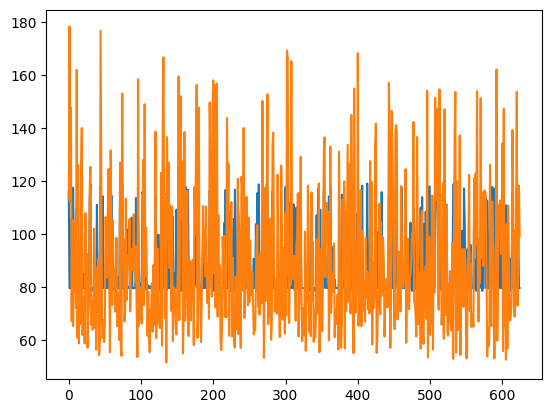

In [25]:
prediction_distribution = model(X_test_red)
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_stdv = prediction_distribution.stddev().numpy()
print(get_mae_error(prediction_mean, y_test_red).mean())

plt.plot(prediction_mean[:625])
plt.plot(y_test_red[:625])
#print(prediction_stdv)

In [9]:
def get_efficiency1(prediction_mean, ci_width):
  mean_ci_width = ci_width.mean()
  mae_error = get_mae_error(prediction_mean, y_test_red).mean()
  efficiency_score = compute_efficiency_score1(mae_error, mean_ci_width)
  return efficiency_score

In [10]:
efficiency_scores = []
sigma_values = range(0, 50, 1)
for sigma in sigma_values:
  X_pertubed = X_test_red + np.random.normal(0,sigma, size=X_test_red.shape)
  prediction_distribution = model(X_pertubed)
  prediction_mean = prediction_distribution.mean().numpy().tolist()
  prediction_stdv = prediction_distribution.stddev().numpy()

  upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
  lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()

  ci_width = 2 * 1.96 * prediction_stdv
  
  efficiency_scores.append(get_efficiency1(prediction_mean, ci_width))
  print('\r' + ' Progress: ' + str(round(100 * sigma/ 50, 2)) + '% complete..', end="")

 Progress: 98.0% complete..

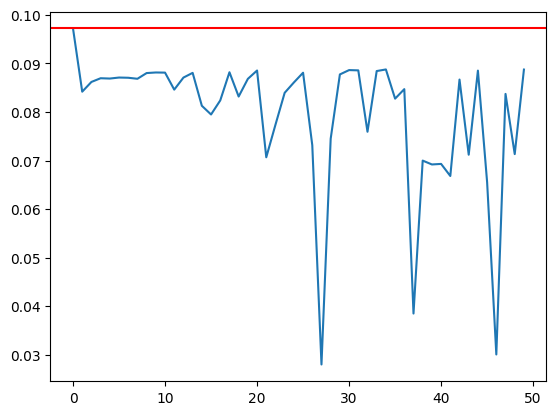

In [12]:
plt.plot(efficiency_scores)
plt.axhline(y = efficiency_scores[0], color = 'r', linestyle = '-')